# Practical 8 & 9. Run you own population genomic analyses!

You have so far analysed population genomic data in a guided, step-by-step way. In this practical you will apply the population genetics knowledge and data skills you have gained so far to explore a new dataset on your own. Use the code and your notes from the previous practicals!

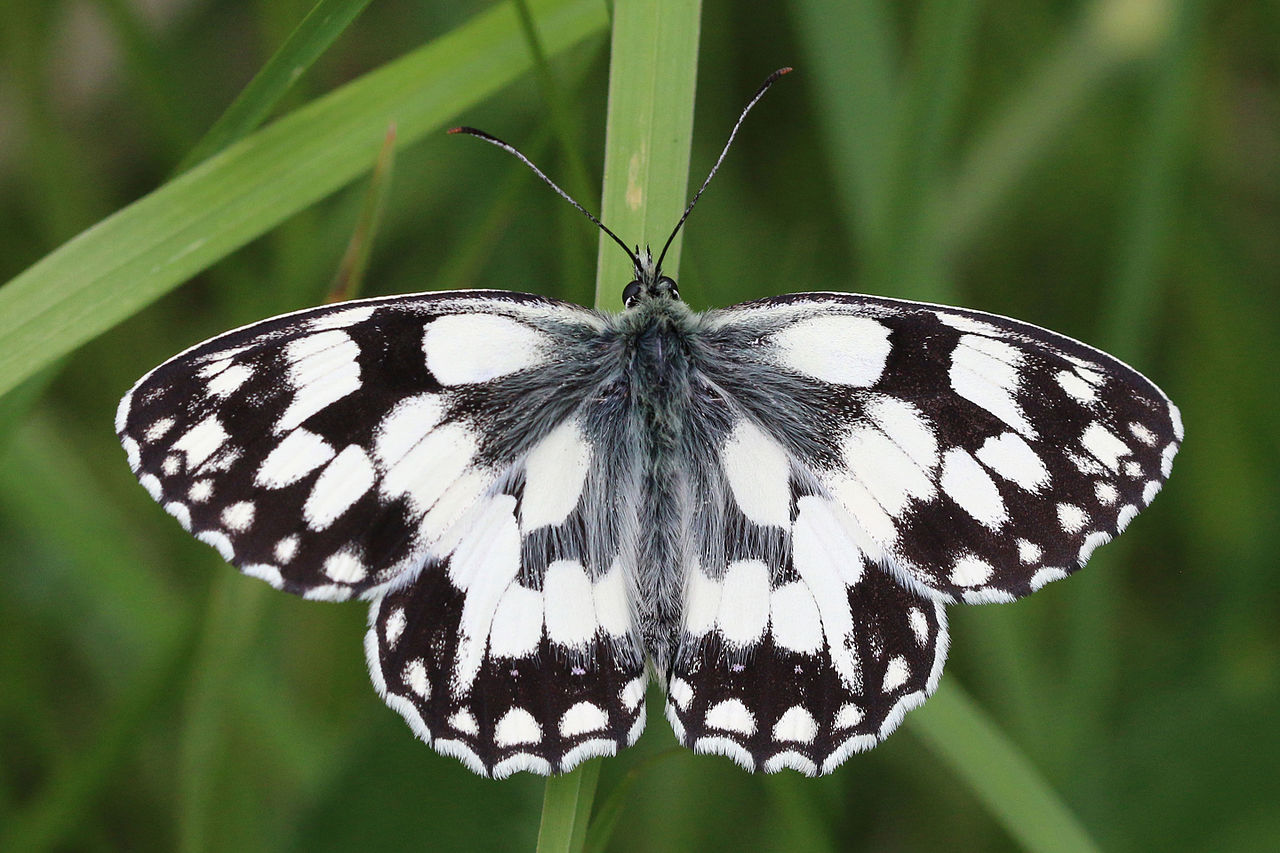

## 8.0 Import data

In [4]:
import msprime
import tskit
import numpy as np
import pandas as pd
import allel
import pysam
import pybedtools
import seaborn as sns
from IPython.display import SVG, set_matplotlib_formats
from matplotlib import pyplot as plt
#jupyter magic
%matplotlib inline
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

We will import a variant only vcf file containing variation data of several individuals from two closely related European butterfly species in the genus *Melanargia*:

- *M. galathea* (Marbled White, Western Palaearctic excluding most of Iberia) 
- *M. lachesis* (Iberian Marbled White, Iberia)

These data were obtained by mapping WGS Illumina reads against the *Melanargia galathea* [reference genome](https://wellcomeopenresearch.org/articles/7-123/v1). The two species meet at a narrow hybrid zone in Southern France (at a very similar location as the *Iphiclides* hybrid zone we encountered in practial 4). The resequence data for eight individual *M. galathea* and seven *M. lachesis* individuals were generated by the Lohse Lab and are unpublished. Individuals were sampled throughout the range of each species:

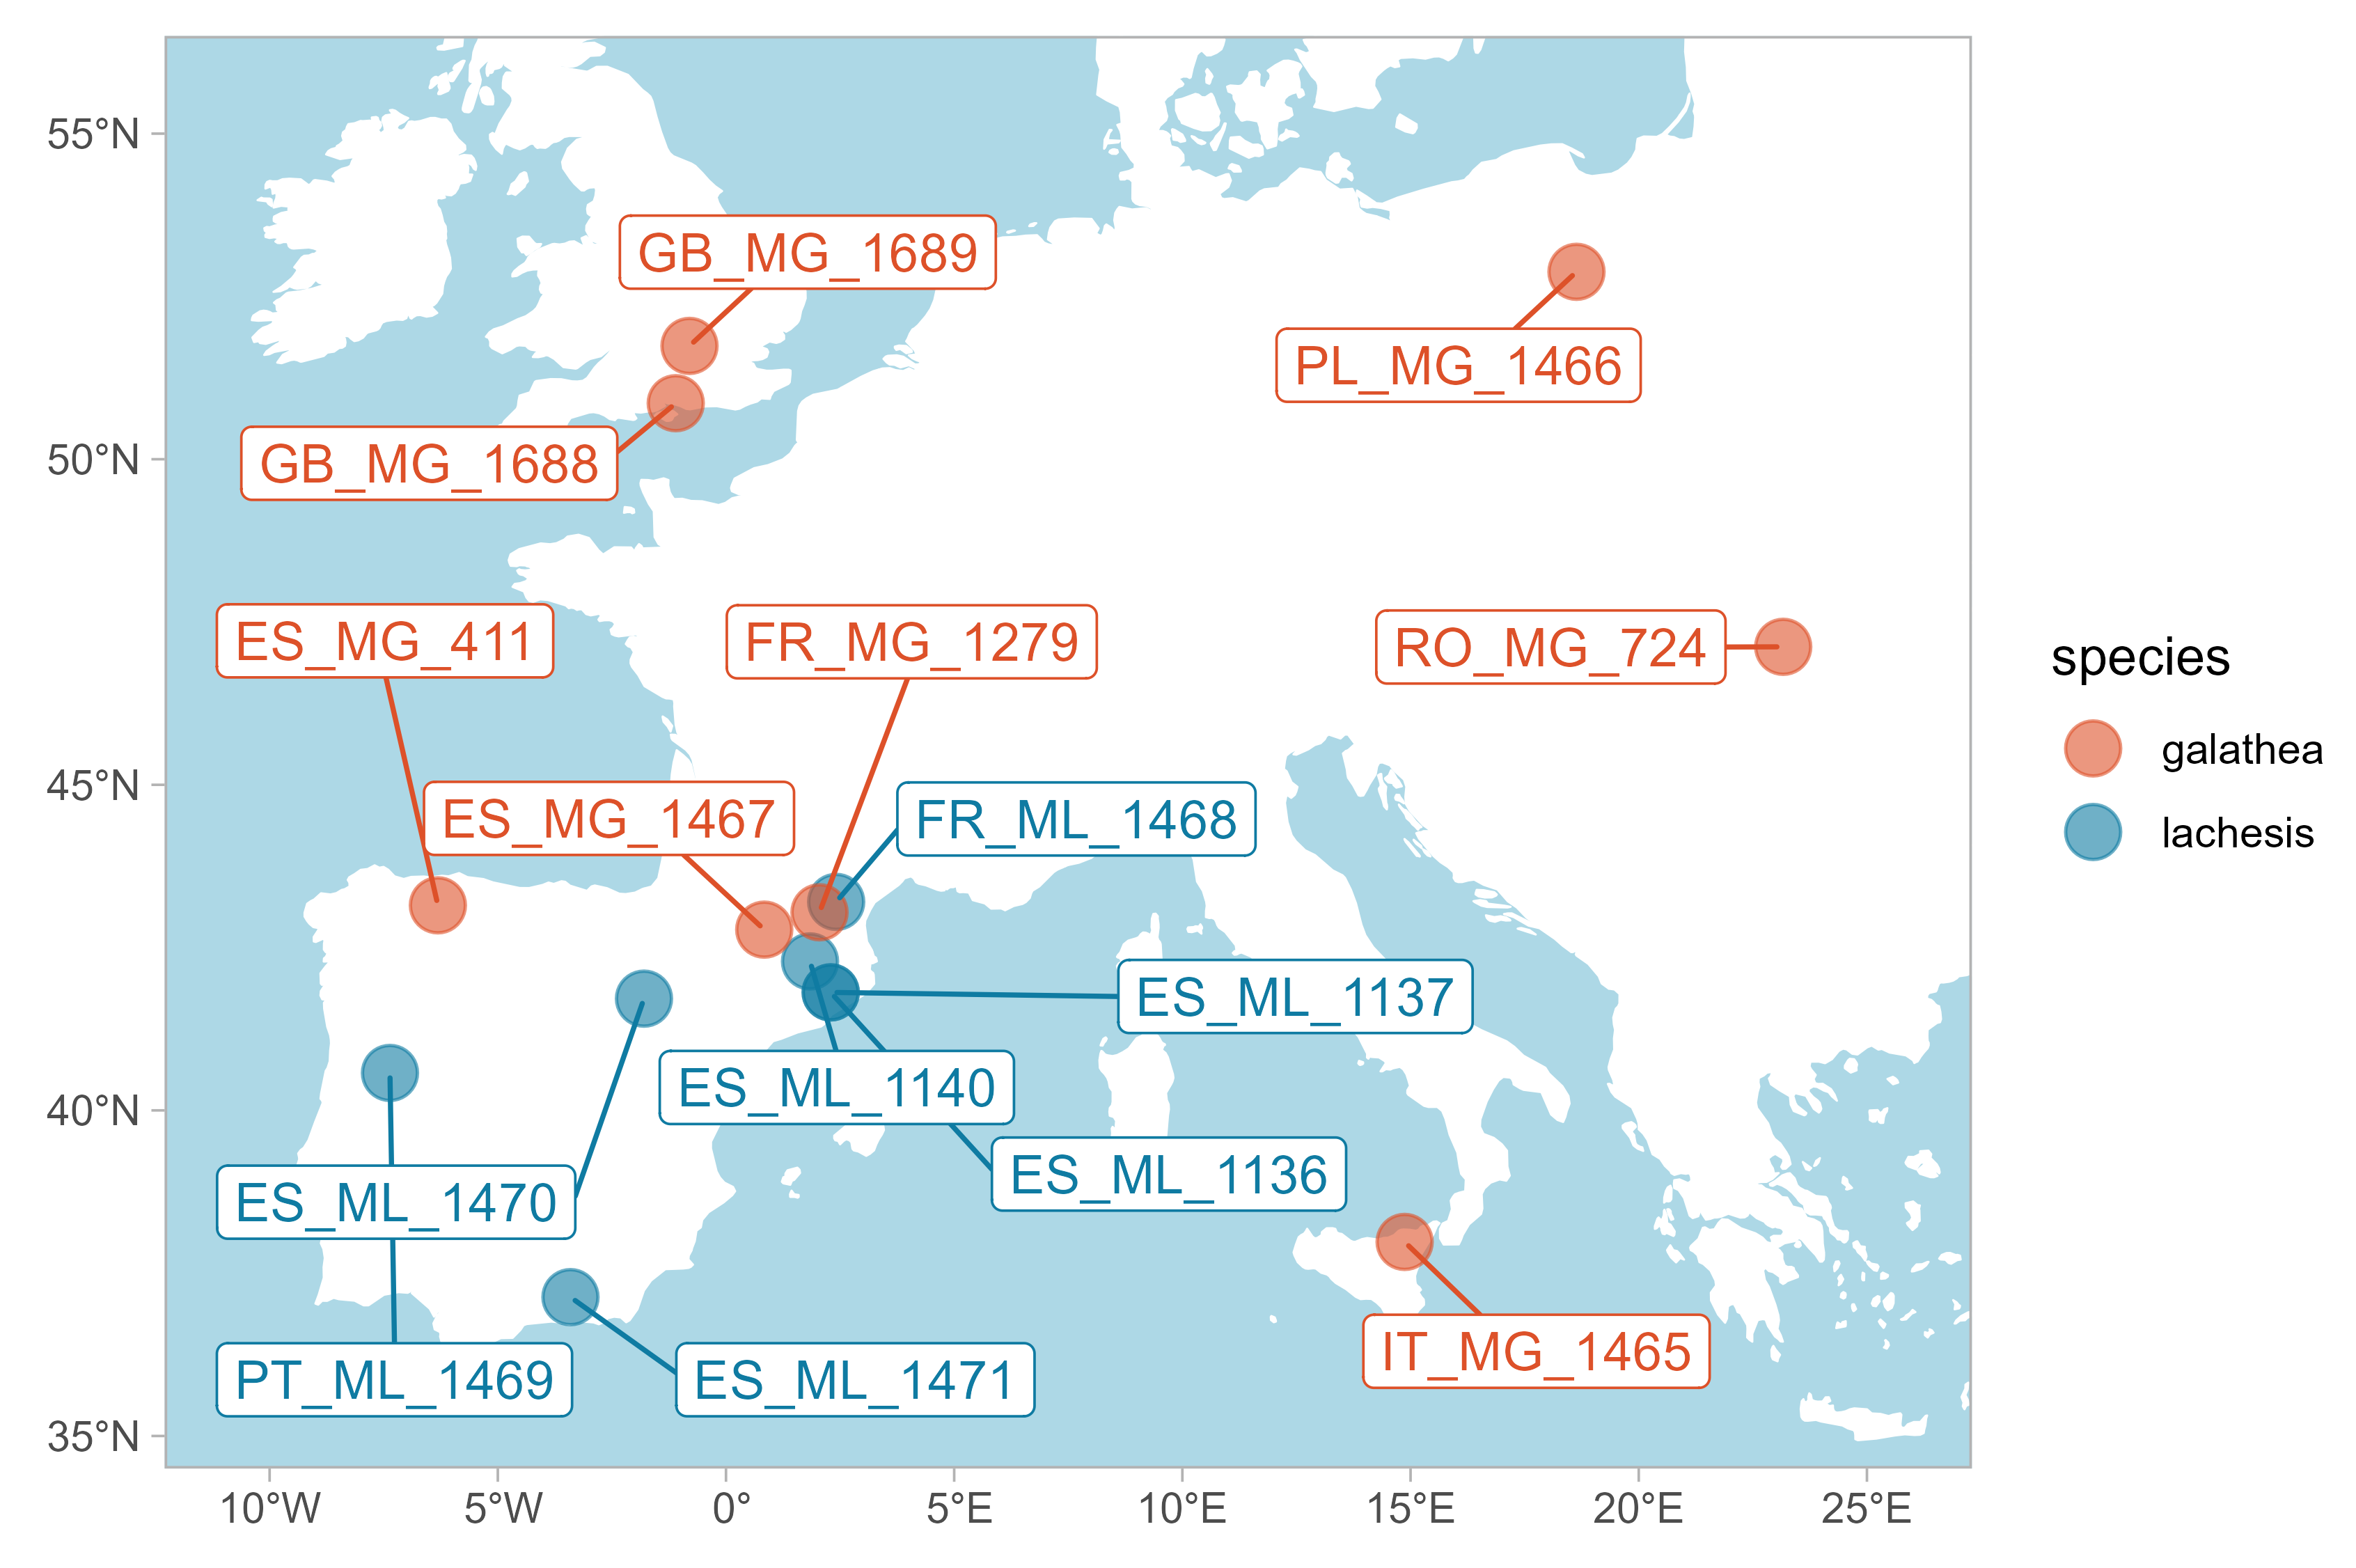

Each student will work on a separate dataset (a different chromosome) which is composed of:

- `melanargia.vcf.gz` containing genotypes of 8 individual *M. galathea* and 7 *M. lachesis* samples called along one *Melanargia galathea* chromosome.
- `melanargia.intergenic.bed` a BED file delimiting intergenic regions along the *M. galathea* genome.
- `melanargia.autosomal.callable.bed.gz` a BED file delimiting callable regions along the *M. galathea* genome.
- `melanargia_samples.csv` containing sample information.
- `melanargia_chroms.csv` containing the length of chromosomes.

Please see the following GoogleSheet for the link to the zipped archive with the data you have been allocated. 

https://docs.google.com/spreadsheets/d/14xvNE-zmYMdWyLwSTsoUUIHobCF4cKnSju_k6Rk_NBI/edit?usp=sharing

Please copy **your** dropbox link into the cell below and execute it to download and decompress the data.

In [ ]:
! wget --no-check-certificate 'https://www.dropbox.com/scl/fi/poduvdgpexslmibhiru0y/p8_data_2024_chrom3.zip?rlkey=r1i9r8h79ytfr096bx6o0q9pz&dl=0' -q --show-progress -O p8_data_test.zip

In [ ]:
! unzip p8_data_test.zip

Once the above cell finishes executing,you will have a folder:
- `p8_data_2024_chrom?`

containing your genomic data files.

Take a look at the metadata for the samples contained in the vcf file (you need to change the folder name) and the chromosomes in the reference genome:

In [7]:
df_samples = pd.read_csv('p8_data_2024_chrom3/melanargia_samples_2024.csv')
df_samples

,sample_id,species_id,country,sex
0,ES_MG_411,Melanargia_galathea,Spain,M
1,RO_MG_724,Melanargia_galathea,Romania,F
2,ES_ML_1136,Melanargia_lachesis,Spain,F
3,ES_ML_1137,Melanargia_lachesis,Spain,M
4,ES_ML_1140,Melanargia_lachesis,Spain,F
5,FR_MG_1279,Melanargia_galathea,France,F
6,IT_MG_1465,Melanargia_galathea,Italy,F
7,PL_MG_1466,Melanargia_galathea,Poland,F
8,ES_MG_1467,Melanargia_galathea,Spain,M
9,FR_ML_1468,Melanargia_lachesis,France,F


In [8]:
sample_ids = df_samples['sample_id'].values
country_ids = df_samples['country'].values
country_id_by_sample_id = {sample: country for sample, country in zip(sample_ids,country_ids)}

In [9]:
df_chroms = pd.read_csv('p8_data_2024_chrom3/melanargia_chroms.csv')
df_chroms

,Unnamed: 0,chrom,lengths
0,0,chromosome_1,42613449
1,1,chromosome_2,34186354
2,2,chromosome_3,33664734
3,3,chromosome_4,30963007
4,4,chromosome_5,27255294
5,5,chromosome_6,26486638
6,6,chromosome_7,26080669
7,7,chromosome_8,25864477
8,8,chromosome_9,25718854
9,9,chromosome_10,25507680


## 8.1 Principle component analysis

In the first section of the practical, you will be performing a principle component analysis (PCA). A [PCA](https://faculty.washington.edu/tathornt/SISG2015/lectures/assoc2015session05.pdf) is a very useful non-parametric technique for sumarising high dimensional data into orthogonal (uncorrelated) principal components or axes. PCAs are widely used for visualizing population genomic variation. The wrapper function below imports data from your vcf file and filters the genotype array for use in a PCA (it mainly uses `allel` functions you have used in previous practicals so you should be able to work out how the data are filtered):

In [7]:
def load_pca_data(sample_ids):
    query_fields = ['samples', 'calldata/GT', 'variants/CHROM', 'variants/POS']
    # loading the data
    vcf_f = "p8_data_2024/melanargia.chromosome_3.vcf.gz"
    vcf_dict = allel.read_vcf(vcf_f, fields=query_fields, samples=sample_ids)
    vcf_samples = vcf_dict['samples']
    # subsetting biallelic SNPs
    snp_gts_raw = vcf_dict['calldata/GT']
    snp_pos_raw = vcf_dict['variants/POS']
    # making genotype array
    snp_ga_raw = allel.GenotypeArray(snp_gts_raw)
    # making allele count array
    snp_ac_raw = snp_ga_raw.count_alleles()
    # create mask for SNPs that are biallelic NOT singletons and ARE segregating. This filter is crucial!
    pca_mask = (snp_ac_raw.is_biallelic_01()& ~snp_ac_raw.is_singleton(0) & ~snp_ac_raw.is_singleton(1) & snp_ac_raw.is_segregating())
    snp_gts_pca = snp_gts_raw[pca_mask]
    snp_pos_pca= snp_pos_raw[pca_mask]
    snp_ga_pca = allel.GenotypeArray(snp_gts_pca)
    # Finally, transform the genotype data into a 2-dimensional matrix where each cell has the number of 
    # non-reference alleles per call. This is what we’ll use as the input to PCA.
    snp_gn_pca = snp_ga_pca.to_n_alt()
    return (snp_gn_pca, vcf_samples)

In [9]:
# load data
snp_gn_pca, vcf_samples = load_pca_data(sample_ids)
# make PCA
pca_coords, pca_model = allel.pca(snp_gn_pca, n_components=3)

In [10]:
import matplotlib as mpl
def plot_pca(coords, model, pc_x, pc_y, sample_ids, country_id_by_sample_id, figsize=(20,20)):
    # create colour palette
    palette = sns.color_palette('colorblind')
    # subset palette based on unique values in array
    cmap = mpl.colors.ListedColormap([palette[i] for i in range(len(set(list(country_id_by_sample_id.values()))))])
    fig, ax = plt.subplots(figsize=figsize, dpi=200)
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc_x] 
    y = coords[:, pc_y] 
    for i, (country_id) in enumerate(set(country_id_by_sample_id.values())):
        mask = [(country_id_by_sample_id[sample_id] == country_id) for sample_id in sample_ids]
        ax.plot(x[mask], y[mask], marker='o', linestyle=' ', label=country_id, markersize=6, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc_x+1, model.explained_variance_ratio_[pc_x]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc_y+1, model.explained_variance_ratio_[pc_y]*100))
    for i, sample_id in enumerate(sample_ids):
        plt.annotate(sample_id, (x[i], y[i]), annotation_clip=False, fontsize=6)
    ax.legend(bbox_to_anchor=(1.05, 0.5), loc='lower right')
    fig.tight_layout()

In [ ]:
plot_pca(pca_coords, pca_model, 0, 1, vcf_samples, country_id_by_sample_id, figsize=(5,5))

It is perhaps more interesting to use PCA to visualize genetic structure within each taxon. The code chunk below uses the two wrapper functions defined above to generate a PCA that includes only the *M. lachesis* samples:

In [12]:
#Subset df_samples for the M_lachesis samples
df_samples_melanargia_lachesis = df_samples[df_samples['species_id']=='Melanargia_lachesis']

In [ ]:
sample_ids = df_samples_melanargia_lachesis['sample_id'].values
country_ids = df_samples_melanargia_lachesis['country'].values
country_id_by_sample_id = {sample: country for sample, country in zip(sample_ids, country_ids)}
# load data
snp_gn_pca, vcf_samples = load_pca_data(sample_ids)
# make PCA
pca_coords, pca_model = allel.pca(snp_gn_pca, n_components=10)
plot_pca(pca_coords, pca_model, 0, 1, vcf_samples, country_id_by_sample_id, figsize=(5,5))

<div class="alert alert-block alert-success">  
<b>Exercise 1 (20 points):</b> 

- Generate an analogous PCA plot for *M. galathea*.
- To what extent does genetic structure in this species reflect geography (i.e. sampling location)? Does your PCA support the conclusion about the oldest intraspecific split in *M. galathea* reached by a previous study on genetic diversity based on allozyme markers and mitochondrial sequences [(Habel et al 2011)](https://wellcomeopenresearch.org/articles/7-123/v1)?
- How does heterozygosity vary between *M. galathea* and *M. lachesis* individuals and what could explain this variation? 
    </div>

## 8.2 Describe and interpret diversity

<div class="alert alert-block alert-success">  
<b>Exercise 2 (20 points):</b>
Analyse the variation at intergenic (and callable) sites to answer the following questions:
<ul>

<li> What fraction of the genome  is intergenic, what fraction of intergenic sites is callable?</li> 
<li> What is the level of neutral genetic diversity in each of the two species?</li> 
<li> What effective population sizes do these estimates imply? Assume neutrality and a per base and per generation mutation rate for butterflies of $\mu =2.9 * 10^{-9}$

[(Keightley et al 2013)](https://academic.oup.com/mbe/article/32/1/239/2925597) (see practical 7), </li>
<li> Does the genetic diversity of each the species reflect its relative geographic range size?</li> 
    </ul>
    </div>

To subset the GT counts to a single taxon, it is easiest to use the sample indices as an argument of `count_alleles` (this is analogous to the subsetting by taxon in practical 7).

In [10]:
query_fields = ['samples', 'calldata/GT', 'variants/CHROM', 'variants/POS']
# loading the data
vcf_f = "p8_data_2024_chrom3/melanargia.chromosome_3.vcf.gz"
vcf_dict = allel.read_vcf(vcf_f, fields=query_fields, samples=sample_ids)
vcf_samples = vcf_dict['samples']

snp_gts_raw = vcf_dict['calldata/GT']
snp_pos_raw = vcf_dict['variants/POS']

# making genotype array
snp_ga_raw = allel.GenotypeArray(snp_gts_raw)
# making allele count array
snp_ac_raw = snp_ga_raw.count_alleles()

To compuite diversity across all individuals and all sites *(note that computing diversity across species is non-sensical):

In [11]:
allel.sequence_diversity(snp_pos_raw, snp_ac_raw)

0.007999292437014137

To compute diversity for a particular partition, we need to define a boolian mask for this partition and pass it to `allel.sequence_diversity()`:

In [28]:
intergenic_f = 'p8_data_2024_chrom3/melanargia.intergenic.bed.gz'
call_f = 'p8_data_2024_chrom3/melanargia.autosomal.callable.bed.gz'
chrom3_f = 'p8_data_2024_chrom3/chrom3.bed'

In [29]:
intergenic_intervals = pybedtools.BedTool(intergenic_f)
chrom3_intervals = pybedtools.BedTool(chrom3_f)
#e.g. we can intersect the intergenic and 3rd chrom bed files, to get the intergenic intervals on chrom 3: 
inter_3 = intergenic_intervals.intersect(chrom3_intervals)

In [30]:
def bed_to_array(bed):
    big_pos_list = []
    for interval in bed:
        big_pos_list.extend(np.arange(interval.start, interval.end))
    return np.asarray(big_pos_list)

In [31]:
def bed_to_boolian_chrom(bed,chrom_end):
    big_pos_list = bed_to_array(bed)
    mask = np.isin(np.arange(0, chrom_end), big_pos_list, assume_unique=True)
    return mask

.... so to generate a boolian mask specifying intergenic positions on chrom 3 we use the function `bed_to_boolian_chrom`

In [32]:
chrom3 = df_chroms['lengths'][2]
the_big_mask = bed_to_boolian_chrom(inter_3, chrom3)
# this is the length of the chromsome:
print([len(the_big_mask),  chrom3])

[33664734, 33664734]


In [26]:
def get_bed_length(bed_intervals):
    return sum([(bed_interval.end - bed_interval.start) for bed_interval in bed_intervals])

In [33]:
allel.sequence_diversity(snp_pos_raw, snp_ac_raw, is_accessible = the_big_mask)

0.007128570171410457

## 8.3 Divergence between species

<div class="alert alert-block alert-success">  
<b>Exercise 3 (20 points): </b>Analyse the variation at intergenic sites and answer the following questions:
<ul>
<li> What is the mean genetic divergence $d_{xy}$ between <i>M. galathea</i> and <i>M. lachesis</i>?</li>
<li> How does your estimate of $d_{xy}$ for <i>M. galathea</i> and <i>M. lachesis</i> differ from that reported by <a href="https://onlinelibrary.wiley.com/doi/full/10.1111/mec.15981"> Ebdon et al (2019, Table 1)</a> and what could explain the difference?</li>
<li> Are there any conspicuous outliers of divergence and/or differentiation i.e. $F_{ST}$ along your chromosome?</li>    
    </div>

## 8.4 Pick a popgen question!

<div class="alert alert-block alert-success">  
<b>Exercise 4 (40 points): Choose ONE of the three questions below:</b> 

1. Glacial cycles are often associated with contractions and expansions in population size. Does the (folded) SFS for *M. lachesis* support a model of recent population growth? If so, what are the best fitting parameters (see practical 2).

2. What evidence is there for hard selective sweeps along your focal chromosome (see practical 5)? Are there regions that show a signal for a recent sweep in both species? What could explain such apparently parallel sweep signals? (THIS ONE IS HARD)
    
    
    
3. The data for *M. galathea* includes samples from Iberia, the Balkans and Italy. These areas served as glacial refugia for temperate organisms (see <a href="https://www.nature.com/articles/35016000"> Hewitt 2000</a> for a review). Compute pairwise $d_a$ between Iberia, Italy and the Balkan sample to estimate when the current populations in these refugia diverged (note that *Melanargia* has 1 generation per year). Are your estimates of intraspecific population divergence compatible with divergence during the last interglacial or do they suggest an older or more recent population splits? How does intraspecific divergence compare to the estimates of between species divergence? What assumptions do your estimates of population divergence make?
    
Regardless of your choosen question, please include some notes (a few sentences) about how you would improve your inference. Avoid making the obvious point that analysing more data (i.e. more individuals and more chromosomes) is a good idea.
    </div>